In [1]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 15  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [9]:
in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))

100%|██████████| 50/50 [03:37<00:00,  4.35s/it]

cmb0F_1 (500, 800, 401)
kCmbF_1 (500, 800, 401)
lCmbF_1 (500, 800, 401)
lCmbF_o1_1 (100, 800, 401)
lCmbF_o2_1 (100, 800, 401)
lCmbF_o3_1 (100, 800, 401)
lCmbF_o4_1 (100, 800, 401)
fgF_1 (500, 800, 401)
noiseF_1 (500, 800, 401)
totalF_1 (500, 800, 401)
totalF_0 (500, 800, 401)


In [99]:
from multiprocessing import Pool, cpu_count

def calculate_Cls(idx):
    Cls = []
    nBins = 51
    for idx2 in range(1):
        kCmbFourier = in_data['kCmbF_1'][idx]
        TCmbFourier = in_data['cmb0F_1'][idx2]
        phiFourier = baseMap.phiFromKappa(kCmbFourier)
        c_ps_data = [0,0,0]
        c_ps_data[0], c_ps_data[1], c_ps_data[2] = baseMap.crossPowerSpectrum(dataFourier1=TCmbFourier, 
                                                                              dataFourier2=phiFourier, 
                                                                              nBins=nBins)
        if(len(Cls)==0):
            Cls = np.array([c_ps_data])
        else:
            Cls = np.vstack((Cls, np.array([c_ps_data])))
    return Cls

num_processes = 32
pool = Pool(processes=num_processes)
results = list(tqdm(pool.imap(calculate_Cls, range(500)), total=500))
Cls = np.vstack(results)


100%|██████████| 500/500 [00:00<00:00, 591.84it/s]


In [100]:
print(np.shape(Cls))

(500, 3, 50)


In [101]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls


500 (500, 3, 50)


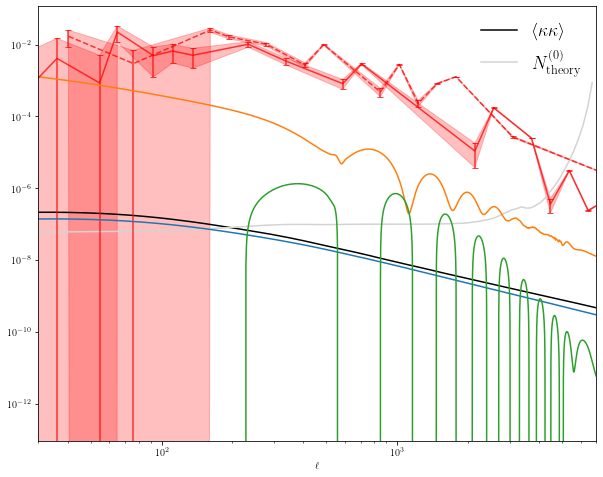

In [102]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))
factor = lambda l : (l*(l+1))**2/(2*np.pi)
ell = baseMap.l.flatten()
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, ClExpected, sty, label=l)

lCen, Cl, sCl = combine_Cl(np.array(Cls))

Cl = factor(lCen)*(Cl)
sCl = factor(lCen)*sCl

tmp = [0 for l in lCen]
lCen += tmp

Ipos = np.where(Cl>=1e-30)
Ineg = np.where(Cl<=-1e-30)

ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
            fmt='-', capsize=3, capthick=1, c='red')
tmp_data = {
    'x': lCen[Ipos],
    'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
    'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
ax.fill_between(**tmp_data,  alpha=.25, color='red')


ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
            fmt='--', capsize=3, capthick=1, c='red')
tmp_data = {
    'x': lCen[Ineg],
    'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
    'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
ax.fill_between(**tmp_data,  alpha=.25, color='red')


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)
labels = ['TT', 'EE', 'BB', 'TE','PP','TP','EP']
for tmp in [
            'n1_data/test_data_set_lenspotentialCls.dat',  #unlensed TT
#             'n1_data/N1_All_analytical.dat', 
#             'n1_data/N0_analytical.dat',
#             'n1_data/test_data_set_lensedCls.dat' #lsendTT
]:
    asdf = np.loadtxt(tmp).T
    l_dat = asdf[0]
    for i in range(len(asdf)-1):
        if(labels[i] not in ['PP', 'TP', 'EP']):
            continue
        phiphi = asdf[i+1]
        plt.plot(l_dat, phiphi, label=labels[i])



In [96]:
# I don't think this is working